## Prepare adata

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import scanpy as sc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/female"

In [40]:
adata_with_labels_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/scANVI_v2.h5ad'
adata = sc.read_h5ad(adata_with_labels_file)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [41]:
adata

AnnData object with n_obs × n_vars = 87916 × 4000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colo

In [42]:
female_adata = adata[adata.obs['sex'] == 'F']
#male_adata = adata[adata.obs['sex'] == 'M']

In [43]:
#get cell type counts
cell_type_counts = female_adata.obs['C_scANVI'].value_counts()
print(cell_type_counts)

C_scANVI
Fast IIX         18391
Fast IIB         16189
MTJ               1951
EC                1650
FAPs              1126
Skeleton MuSc     1059
Pericyte           961
NMJ                785
Tendon             588
Macrophages        428
Name: count, dtype: int64


## Subset the dataset to cell type of interest

In [44]:
female_adata_fast2x = female_adata[female_adata.obs['C_scANVI'] == 'Fast IIX']
female_adata_fast2x

View of AnnData object with n_obs × n_vars = 18391 × 4000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'condi

In [45]:
female_adata_fast2x.X = female_adata_fast2x.layers["log1p_norm_cb"]
print(female_adata_fast2x.X.max())
print(female_adata_fast2x.X.min())

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_15009/1511221784.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  female_adata_fast2x.X = female_adata_fast2x.layers["log1p_norm_cb"]


4.907343
0.0


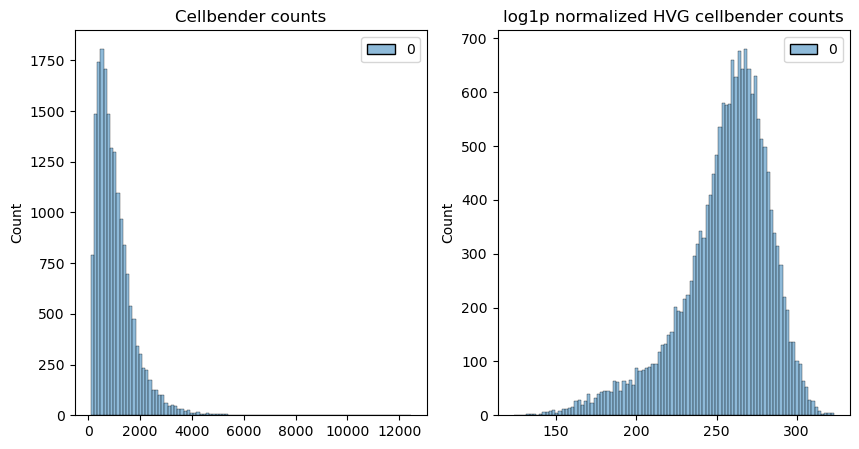

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(female_adata_fast2x.layers["cellbender"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Cellbender counts")
p2 = sns.histplot(female_adata_fast2x.layers["log1p_norm_cb"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("log1p normalized HVG cellbender counts")
# p1 = sns.histplot(adata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
# axes[0].set_title("Counts")
# p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
# axes[1].set_title("Log1p normalized counts")
plt.show()

#### Filter features with std dev = 0

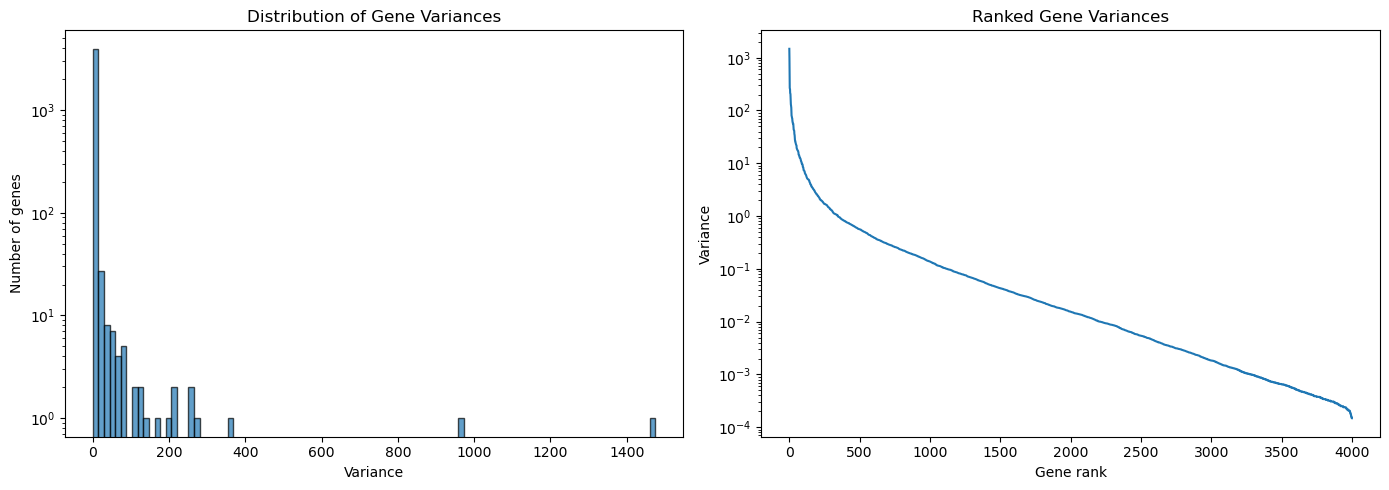

In [47]:
# plot the var variances

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(female_adata_fast2x.var['variances'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Variance')
axes[0].set_ylabel('Number of genes')
axes[0].set_title('Distribution of Gene Variances')
axes[0].set_yscale('log')

sorted_var = np.sort(female_adata_fast2x.var['variances'])[::-1]
axes[1].plot(sorted_var)
axes[1].set_xlabel('Gene rank')
axes[1].set_ylabel('Variance')
axes[1].set_title('Ranked Gene Variances')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

#### Sparsity based filtering

In [48]:
import numpy as np
from scipy.sparse import issparse

def calculate_zero_proportion(adata, axis='genes'):
    """
    Calculate the proportion of zeros for either genes (features) or cells in an AnnData object.
    
    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing gene expression data
    axis : str, default 'genes'
        Which axis to calculate zeros for:
        - 'genes' or 'features' or 'columns': calculate zeros per gene (column-wise)
        - 'cells' or 'rows': calculate zeros per cell (row-wise)
        
    Returns:
    --------
    proportion_zeros : numpy.ndarray
        Array containing the proportion of zeros for each gene or cell
    """
    if axis.lower() in ['genes', 'features', 'columns']:
        # Calculate zeros per gene (column-wise)
        if issparse(adata.X):
            # For sparse matrix: count non-zeros, then calculate zeros
            n_cells = adata.n_obs
            non_zero_per_gene = np.array((adata.X != 0).sum(axis=0)).flatten()
            zero_per_gene = n_cells - non_zero_per_gene
            proportion_zeros = zero_per_gene / n_cells
        else:
            # For dense matrix
            proportion_zeros = (adata.X == 0).sum(axis=0) / adata.n_obs
            
    elif axis.lower() in ['cells', 'rows']:
        # Calculate zeros per cell (row-wise)
        if issparse(adata.X):
            # For sparse matrix: count non-zeros, then calculate zeros
            n_genes = adata.n_vars
            non_zero_per_cell = np.array((adata.X != 0).sum(axis=1)).flatten()
            zero_per_cell = n_genes - non_zero_per_cell
            proportion_zeros = zero_per_cell / n_genes
        else:
            # For dense matrix
            proportion_zeros = (adata.X == 0).sum(axis=1) / adata.n_vars
    else:
        raise ValueError("axis must be 'genes', 'features', 'columns', 'cells', or 'rows'")
    
    return proportion_zeros


In [49]:
proportion_zeros_feature = calculate_zero_proportion(female_adata_fast2x, axis='features')

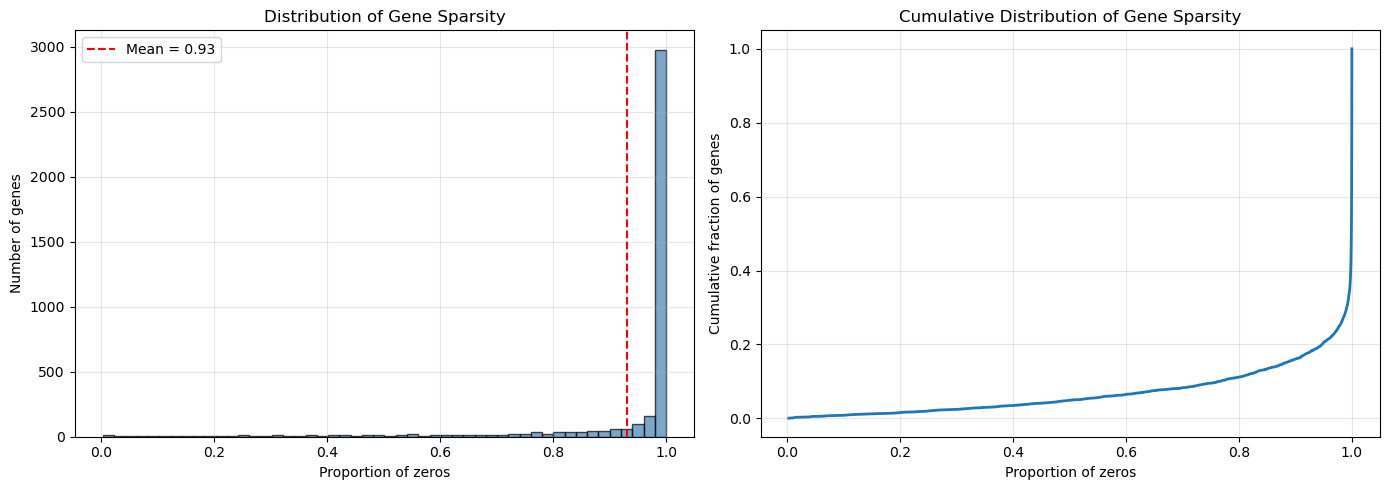

Total genes: 4000
Mean proportion of zeros: 0.931
Median proportion of zeros: 0.999

Genes by sparsity:
  >99% zeros: 2827 genes (70.7%)
  >50% zeros: 3805 genes (95.1%)
  >10% zeros: 3968 genes (99.2%)
  All zeros:  273 genes


In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(proportion_zeros_feature, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Proportion of zeros')
axes[0].set_ylabel('Number of genes')
axes[0].set_title('Distribution of Gene Sparsity')
axes[0].axvline(proportion_zeros_feature.mean(), color='red', linestyle='--', 
                label=f'Mean = {proportion_zeros_feature.mean():.2f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Cumulative distribution
sorted_props = np.sort(proportion_zeros_feature)
cumulative = np.arange(1, len(sorted_props) + 1) / len(sorted_props)
axes[1].plot(sorted_props, cumulative, linewidth=2)
axes[1].set_xlabel('Proportion of zeros')
axes[1].set_ylabel('Cumulative fraction of genes')
axes[1].set_title('Cumulative Distribution of Gene Sparsity')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Total genes: {len(proportion_zeros_feature)}")
print(f"Mean proportion of zeros: {proportion_zeros_feature.mean():.3f}")
print(f"Median proportion of zeros: {np.median(proportion_zeros_feature):.3f}")
print(f"\nGenes by sparsity:")
print(f"  >99% zeros: {(proportion_zeros_feature > 0.99).sum()} genes ({(proportion_zeros_feature > 0.99).sum()/len(proportion_zeros_feature)*100:.1f}%)")
print(f"  >50% zeros: {(proportion_zeros_feature > 0.5).sum()} genes ({(proportion_zeros_feature > 0.5).sum()/len(proportion_zeros_feature)*100:.1f}%)")
print(f"  >10% zeros: {(proportion_zeros_feature > 0.1).sum()} genes ({(proportion_zeros_feature > 0.1).sum()/len(proportion_zeros_feature)*100:.1f}%)")
print(f"  All zeros:  {(proportion_zeros_feature == 1.0).sum()} genes")

In [51]:
# Remove genes with all zeros
genes_to_keep = proportion_zeros_feature < 1.0

print(f"Before filtering: {female_adata_fast2x.n_vars} genes")
female_adata_fast2x = female_adata_fast2x[:, genes_to_keep]
print(f"After filtering: {female_adata_fast2x.n_vars} genes")
print(f"Removed: {(~genes_to_keep).sum()} all-zero genes")

Before filtering: 4000 genes
After filtering: 3727 genes
Removed: 273 all-zero genes


In [52]:
proportion_zeros_cell = calculate_zero_proportion(female_adata_fast2x, axis='cells')

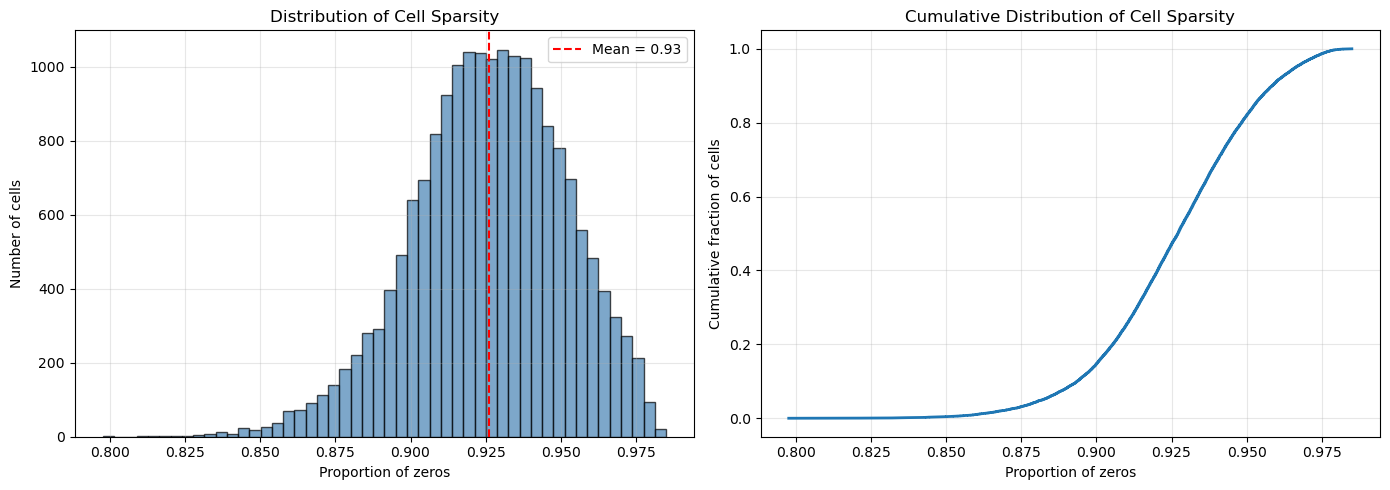

Total cells: 18391
Mean proportion of zeros: 0.926
Median proportion of zeros: 0.927

Cell by sparsity:
  >95% zeros: 3330 cells (18.1%)
  >94% zeros: 5614 cells (30.5%)
  >90% zeros: 15680 cells (85.3%)
  All zeros:  0 cells


In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(proportion_zeros_cell, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Proportion of zeros')
axes[0].set_ylabel('Number of cells')
axes[0].set_title('Distribution of Cell Sparsity')
axes[0].axvline(proportion_zeros_cell.mean(), color='red', linestyle='--', 
                label=f'Mean = {proportion_zeros_cell.mean():.2f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Cumulative distribution
sorted_props = np.sort(proportion_zeros_cell)
cumulative = np.arange(1, len(sorted_props) + 1) / len(sorted_props)
axes[1].plot(sorted_props, cumulative, linewidth=2)
axes[1].set_xlabel('Proportion of zeros')
axes[1].set_ylabel('Cumulative fraction of cells')
axes[1].set_title('Cumulative Distribution of Cell Sparsity')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Total cells: {len(proportion_zeros_cell)}")
print(f"Mean proportion of zeros: {proportion_zeros_cell.mean():.3f}")
print(f"Median proportion of zeros: {np.median(proportion_zeros_cell):.3f}")
print(f"\nCell by sparsity:")
print(f"  >95% zeros: {(proportion_zeros_cell > 0.95).sum()} cells ({(proportion_zeros_cell > 0.95).sum()/len(proportion_zeros_cell)*100:.1f}%)")
print(f"  >94% zeros: {(proportion_zeros_cell > 0.94).sum()} cells ({(proportion_zeros_cell > 0.94).sum()/len(proportion_zeros_cell)*100:.1f}%)")
print(f"  >90% zeros: {(proportion_zeros_cell > 0.90).sum()} cells ({(proportion_zeros_cell > 0.90).sum()/len(proportion_zeros_cell)*100:.1f}%)")
print(f"  All zeros:  {(proportion_zeros_cell == 1.0).sum()} cells")

In [58]:
# Remove cells
cells_to_keep = proportion_zeros_cell < 0.94

print(f"Before filtering: {female_adata_fast2x.n_obs} cells")
female_adata_fast2x = female_adata_fast2x[cells_to_keep, :]
print(f"After filtering: {female_adata_fast2x.n_obs} cells")
print(f"Removed: {(~cells_to_keep).sum()} all-zero cells")

Before filtering: 18391 cells
After filtering: 12777 cells
Removed: 5614 all-zero cells


In [59]:
female_adata_fast2x

View of AnnData object with n_obs × n_vars = 12777 × 3727
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'condi

## Run slide

In [ ]:
import loveslide
from loveslide import OptimizeSLIDE

/ocean/projects/cis240075p/asachan/.conda/envs/loveslide_dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
During startup - Warning messages:
1: package ‘methods’ was built under R version 4.4.3 
2: package ‘datasets’ was built under R version 4.4.3 
3: package ‘utils’ was built under R version 4.4.3 
4: package ‘grDevices’ was built under R version 4.4.3 
5: package ‘graphics’ was built under R version 4.4.3 
6: package ‘stats’ was built under R version 4.4.3 


In [ ]:
input_params = {
    'x_path': '/path/to/features.csv',
    'y_path': '/path/to/labels.csv',
    'fdr': 0.1,
    'thresh_fdr': 0.1,
    'spec': 0.2,
    'y_factor': True,
    'niter': 500,
    'SLIDE_top_feats': 20,
    'rep_CV': 50,
    'pure_homo': True,
    'delta': [0.01],
    'lambda': [0.5, 0.1],
    'out_path': '/path/to/output/'
}

slider = OptimizeSLIDE(input_params)
slider.run_pipeline(verbose=True, n_workers=1)